In [1]:
# STEP 1: Install packages
!pip install -U xgboost lightgbm catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.2 MB/s eta 0:00:00


In [2]:
# STEP 2: Import Libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, precision_recall_curve, auc
import matplotlib.pyplot as plt

In [3]:
# STEP 3: Load and clean data
df = pd.read_csv('Dataset.csv')
df = df.map(lambda x: x.strip("'") if isinstance(x, str) else x)  # remove quotes
df = df.drop(columns=['zipcodeOri', 'zipMerchant'])

In [4]:
# STEP 4: Encode categorical variables
categorical_cols = ['customer', 'merchant', 'category', 'age', 'gender']
le_dict = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    le_dict[col] = le

In [5]:
# STEP 5: Split into features & target
X = df.drop('fraud', axis=1)
y = df['fraud']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

In [6]:
# STEP 6: Feature Engineering on training set
X_train_fe = X_train.copy()
X_train_fe['log_amount'] = np.log1p(X_train_fe['amount'])
X_train_fe['transaction_hour'] = X_train_fe['step'] % 24
X_train_fe['is_night'] = X_train_fe['transaction_hour'].apply(lambda x: 1 if 0 <= x <= 6 else 0)
X_train_fe['transaction_day'] = X_train_fe['step'] // 24
X_train_fe['is_weekend'] = X_train_fe['transaction_day'] % 7 >= 5

In [7]:
# STEP 7: Outlier Removal using IQR
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return df[(df[column] >= lower) & (df[column] <= upper)]
df_cleaned = X_train_fe.copy()
df_cleaned['fraud'] = y_train
df_cleaned = remove_outliers_iqr(df_cleaned, 'amount')

In [8]:
# STEP 8: Split cleaned data
X_cleaned = df_cleaned.drop('fraud', axis=1)
y_cleaned = df_cleaned['fraud']

In [9]:
# STEP 9: Autoencoder on normal (non-fraud) data
from tensorflow.keras.models import Model
from tensorflow.keras.layers impo rt Input, Dense
import tensorflow as tf

features_for_ae = ['age', 'gender', 'customer', 'merchant', 'category',
                   'log_amount', 'transaction_hour', 'is_night',
                   'transaction_day', 'is_weekend']

X_ae_train = X_cleaned[y_cleaned == 0][features_for_ae]
scaler = MinMaxScaler()
X_ae_scaled = scaler.fit_transform(X_ae_train)

input_dim = X_ae_scaled.shape[1]
input_layer = Input(shape=(input_dim,))
encoded = Dense(16, activation='relu')(input_layer)
encoded = Dense(8, activation='relu')(encoded)
decoded = Dense(16, activation='relu')(encoded)
output_layer = Dense(input_dim, activation='sigmoid')(decoded)

autoencoder = Model(inputs=input_layer, outputs=output_layer)
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.fit(X_ae_scaled, X_ae_scaled, epochs=20, batch_size=32, shuffle=True, validation_split=0.1, verbose=1)


Epoch 1/20
10781/10781 ━━━━━━━━━━━━━━━━━━━━ 27s 2ms/step - loss: 0.0175 - val_loss: 0.0054
Epoch 2/20
10781/10781 ━━━━━━━━━━━━━━━━━━━━ 40s 2ms/step - loss: 0.0053 - val_loss: 0.0049
Epoch 3/20
10781/10781 ━━━━━━━━━━━━━━━━━━━━ 24s 2ms/step - loss: 0.0047 - val_loss: 0.0044
Epoch 4/20
10781/10781 ━━━━━━━━━━━━━━━━━━━━ 23s 2ms/step - loss: 0.0043 - val_loss: 0.0043
Epoch 5/20
10781/10781 ━━━━━━━━━━━━━━━━━━━━ 41s 2ms/step - loss: 0.0043 - val_loss: 0.0042
Epoch 6/20
10781/10781 ━━━━━━━━━━━━━━━━━━━━ 40s 2ms/step - loss: 0.0039 - val_loss: 0.0030
Epoch 7/20
10781/10781 ━━━━━━━━━━━━━━━━━━━━ 42s 2ms/step - loss: 0.0029 - val_loss: 0.0029
Epoch 8/20
10781/10781 ━━━━━━━━━━━━━━━━━━━━ 41s 2ms/step - loss: 0.0029 - val_loss: 0.0029
Epoch 9/20
10781/10781 ━━━━━━━━━━━━━━━━━━━━ 23s 2ms/step - loss: 0.0028 - val_loss: 0.0028
Epoch 10/20
10781/10781 ━━━━━━━━━━━━━━━━━━━━ 23s 2ms/step - loss: 0.0028 - val_loss: 0.0028
Epoch 11/20
10781/10781 ━━━━━━━━━━━━━━━━━━━━ 41s 2ms/step - loss: 0.0028 - val_loss: 0.00

In [10]:
# STEP 10: Anomaly score for train
X_train_scaled = scaler.transform(X_cleaned[features_for_ae])
reconstructed_train = autoencoder.predict(X_train_scaled)
mse_train = np.mean(np.power(X_train_scaled - reconstructed_train, 2), axis=1)
X_cleaned["anomaly_score"] = mse_train

12001/12001 ━━━━━━━━━━━━━━━━━━━━ 15s 1ms/step


In [11]:
# STEP 11: Same feature engineering on test set
X_test_fe = X_test.copy()
X_test_fe['log_amount'] = np.log1p(X_test_fe['amount'])
X_test_fe['transaction_hour'] = X_test_fe['step'] % 24
X_test_fe['is_night'] = X_test_fe['transaction_hour'].apply(lambda x: 1 if 0 <= x <= 6 else 0)
X_test_fe['transaction_day'] = X_test_fe['step'] // 24
X_test_fe['is_weekend'] = X_test_fe['transaction_day'] % 7 >= 5
X_test_scaled = scaler.transform(X_test_fe[features_for_ae])

In [12]:
# STEP 12: Anomaly score for test
reconstructed_test = autoencoder.predict(X_test_scaled)
mse_test = np.mean(np.power(X_test_scaled - reconstructed_test, 2), axis=1)
X_test_fe["anomaly_score"] = mse_test

4182/4182 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


In [13]:
# STEP 13: Prepare data for base models
X_train_final = X_cleaned[features_for_ae + ['anomaly_score']]
X_test_final = X_test_fe[features_for_ae + ['anomaly_score']]
y_train_final = y_cleaned

In [14]:
# STEP 14: Train Base Classifiers
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
cat = CatBoostClassifier(verbose=0)
lgb = LGBMClassifier()

xgb.fit(X_train_final, y_train_final)
cat.fit(X_train_final, y_train_final)
lgb.fit(X_train_final, y_train_final)

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [09:26:07] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[LightGBM] [Info] Number of positive: 709, number of negative: 383308
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.031701 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 876
[LightGBM] [Info] Number of data points in the train set: 384017, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001846 -> initscore=-6.292739
[LightGBM] [Info] Start training from score -6.292739


LGBMClassifier()

In [15]:
# STEP 15: Stacking
stacked_train = pd.DataFrame({
    "xgb": xgb.predict_proba(X_train_final)[:, 1],
    "cat": cat.predict_proba(X_train_final)[:, 1],
    "lgb": lgb.predict_proba(X_train_final)[:, 1],
})
stacked_test = pd.DataFrame({
    "xgb": xgb.predict_proba(X_test_final)[:, 1],
    "cat": cat.predict_proba(X_test_final)[:, 1],
    "lgb": lgb.predict_proba(X_test_final)[:, 1],
})

In [16]:
# STEP 16: Meta model (Logistic Regression)
from sklearn.linear_model import LogisticRegression
meta_model = LogisticRegression()
meta_model.fit(stacked_train, y_train_final)

LogisticRegression()

Classification Report:

              precision    recall  f1-score   support

           0       0.99      1.00      1.00    132172
           1       0.75      0.47      0.58      1623

    accuracy                           0.99    133795
   macro avg       0.87      0.73      0.79    133795
weighted avg       0.99      0.99      0.99    133795


ROC AUC Score: 0.9919


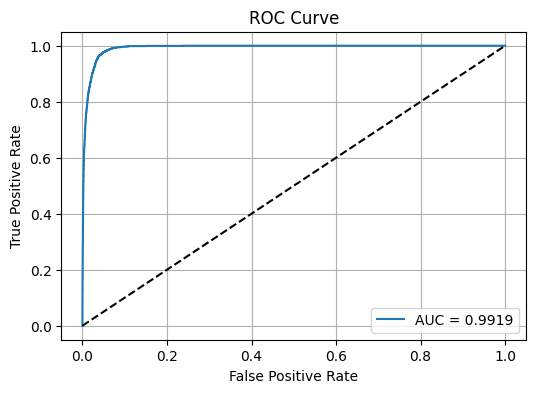

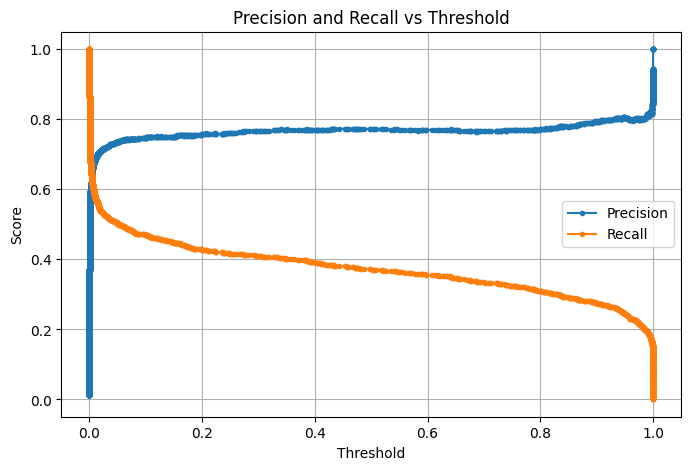

In [21]:
# STEP 17: Evaluate
# y_pred = meta_model.predict(stacked_test)
# y_proba = meta_model.predict_proba(stacked_test)[:, 1]

# print("Classification Report:\n")
# print(classification_report(y_test, y_pred))
# Already predicted probabilities
y_proba = meta_model.predict_proba(stacked_test)[:, 1]

# ✅ Custom threshold instead of default 0.5
threshold = 0.3  # try 0.2, 0.3, 0.4, etc.
y_pred = (y_proba >= threshold).astype(int)

# Re-evaluate
print("Classification Report:\n")
print(classification_report(y_test, y_pred))

roc_auc = roc_auc_score(y_test, y_proba)
print(f"\nROC AUC Score: {roc_auc:.4f}")

fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid()
plt.show()

# precision, recall, _ = precision_recall_curve(y_test, y_proba)
# pr_auc = auc(recall, precision)
# plt.figure(figsize=(6, 4))
# plt.plot(recall, precision, label=f"AUC = {pr_auc:.4f}")
# plt.xlabel("Recall")
# plt.ylabel("Precision")
# plt.title("Precision-Recall Curve")
# plt.legend()
# plt.grid()
# plt.show()

from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_test, y_proba)

plt.figure(figsize=(8, 5))
plt.plot(thresholds, precision[:-1], label='Precision', marker='.')
plt.plot(thresholds, recall[:-1], label='Recall', marker='.')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision and Recall vs Threshold')
plt.grid()
plt.legend()
plt.show()


# Confusion Matrix

<Figure size 500x400 with 0 Axes>

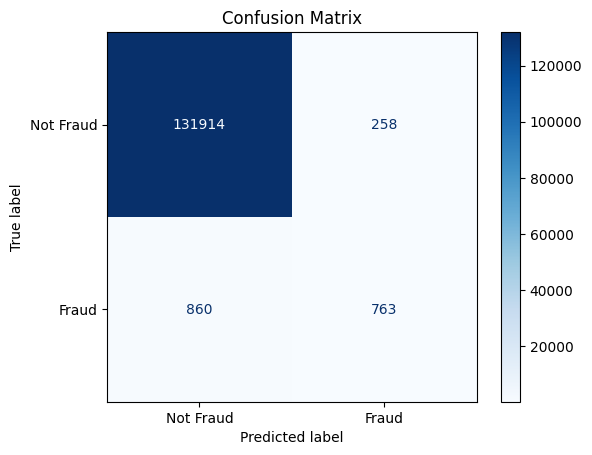

In [22]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Compute and plot the confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Fraud", "Fraud"])

plt.figure(figsize=(5, 4))
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.grid(False)
plt.show()


In [25]:
import numpy as np

# Get coefficients
coefficients = meta_model.coef_[0]  # Shape (n_features,)
feature_names = stacked_train.columns  # Your stacked features

# Zip and sort by absolute value
feature_importance = sorted(zip(feature_names, coefficients), key=lambda x: abs(x[1]), reverse=True)

# Display top 10
print("Top 10 Important Features (by Logistic Coefficients):")
for name, coef in feature_importance[:10]:
    print(f"{name}: {coef:.4f}")


Top 10 Important Features (by Logistic Coefficients):
cat: 12.6400
xgb: 9.6247
lgb: 3.1512


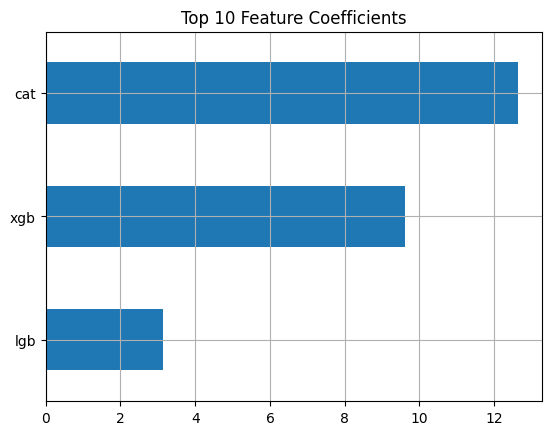

In [24]:
coeffs = pd.Series(meta_model.coef_[0], index=stacked_train.columns).sort_values(key=abs, ascending=False)
coeffs[:10].plot(kind='barh')
plt.title("Top 10 Feature Coefficients")
plt.gca().invert_yaxis()
plt.grid(True)
plt.show()


In [26]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# y_test = true labels (0 or 1)
# y_pred = predicted labels (0 or 1 after thresholding)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='binary')  # default for binary
recall = recall_score(y_test, y_pred, average='binary')
f1 = f1_score(y_test, y_pred, average='binary')

print(f"Overall Accuracy: {accuracy:.4f}")
print(f"Overall Precision: {precision:.4f}")
print(f"Overall Recall: {recall:.4f}")
print(f"Overall F1 Score: {f1:.4f}")


Overall Accuracy: 0.9916
Overall Precision: 0.7473
Overall Recall: 0.4701
Overall F1 Score: 0.5772


In [20]:
# from sklearn.metrics import f1_score

# best_thresh = 0.5
# best_f1 = 0

# for thresh in np.arange(0.1, 0.6, 0.01):
#     preds = (y_proba >= thresh).astype(int)
#     f1 = f1_score(y_test, preds)
#     if f1 > best_f1:
#         best_f1 = f1
#         best_thresh = thresh

# print(f"Best Threshold: {best_thresh}, Best F1 Score: {best_f1}")


Best Threshold: 0.1, Best F1 Score: 0.5771558245083207


In [27]:
import joblib
from tensorflow.keras.models import load_model

# Save Autoencoder
autoencoder.save("autoencoder_model.h5")

# Save scaler
joblib.dump(scaler, "scaler.pkl")

# Save base models
joblib.dump(xgb, "xgb_model.pkl")
joblib.dump(cat, "cat_model.pkl")
joblib.dump(lgb, "lgb_model.pkl")

# Save meta model
joblib.dump(meta_model, "meta_model.pkl")


['meta_model.pkl']

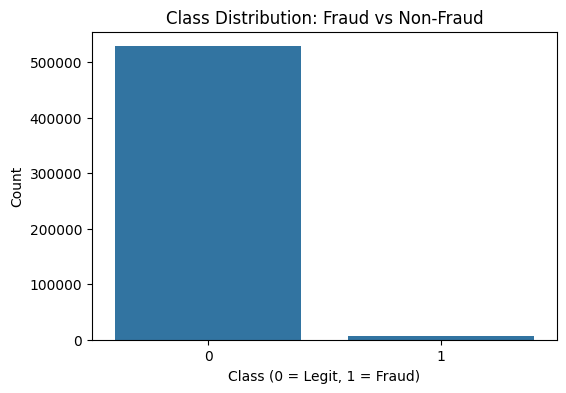

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
sns.countplot(x='fraud', data=df)
plt.title("Class Distribution: Fraud vs Non-Fraud")
plt.xlabel("Class (0 = Legit, 1 = Fraud)")
plt.ylabel("Count")
plt.show()
